In [33]:
import os
import json
import math
import re
from pathlib import Path
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd
import torch
from torch import Tensor

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import HookedTransformer
import transformer_lens.utils as tl_utils
from functools import partial

MODEL_SIZE = 160
BASE_MODEL_NAME = f"EleutherAI/pythia-{MODEL_SIZE}m"

PROJECT_ROOT = Path("..").resolve()
TARGET_MODEL_PATH = PROJECT_ROOT / f"models/{MODEL_SIZE}M/memorized"
CONTROL_MODEL_PATH = PROJECT_ROOT / f"models/{MODEL_SIZE}M/control"
PII_DATA_PATH = PROJECT_ROOT / f"models/{MODEL_SIZE}M/memorized_pii_by_type.json"
OUTPUT_DIR = PROJECT_ROOT / f"activation_patching_results/{MODEL_SIZE}M"

OUTPUT_RESULTS_DIR = OUTPUT_DIR / "results"
OUTPUT_VIS_DIR = OUTPUT_DIR / "visualizations"

PII_TYPES = ["driver_license", "email", "id_number", "passport"]
TOP_N_IMPORTANT_LOCATIONS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

os.makedirs(OUTPUT_RESULTS_DIR, exist_ok=True)
os.makedirs(OUTPUT_VIS_DIR, exist_ok=True)

torch.set_grad_enabled(False)
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Using device: {DEVICE}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Target model path: {TARGET_MODEL_PATH}")
print(f"Control model path: {CONTROL_MODEL_PATH}")
print(f"PII data path: {PII_DATA_PATH}")
print(f"Output directory: {OUTPUT_DIR}")


Using device: cpu
Project root: /Users/georgekontorousis/git/pii_memo
Target model path: /Users/georgekontorousis/git/pii_memo/models/160M/memorized
Control model path: /Users/georgekontorousis/git/pii_memo/models/160M/control
PII data path: /Users/georgekontorousis/git/pii_memo/models/160M/memorized_pii_by_type.json
Output directory: /Users/georgekontorousis/git/pii_memo/activation_patching_results/160M


In [34]:
DEBUG_LOGGING = True

def debug_log(msg: str) -> None:
    if DEBUG_LOGGING:
        print(msg)



In [35]:
from typing import Optional

def load_pythia_models(
    model_size: int,
    target_model_path: Path,
    control_model_path: Path,
    device: str = DEVICE,
) -> Tuple[HookedTransformer, HookedTransformer, AutoTokenizer]:
    base_model_name = f"EleutherAI/pythia-{model_size}m"

    print(f"Loading base model: {base_model_name}")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)

    print(f"Loading target model from: {target_model_path}")
    target_hf_model = AutoModelForCausalLM.from_pretrained(str(target_model_path))

    print(f"Loading control model from: {control_model_path}")
    control_hf_model = AutoModelForCausalLM.from_pretrained(str(control_model_path))

    tl_target_model = HookedTransformer.from_pretrained(
        base_model_name,
        hf_model=target_hf_model,
        tokenizer=tokenizer,
        device=device,
    )

    tl_control_model = HookedTransformer.from_pretrained(
        base_model_name,
        hf_model=control_hf_model,
        tokenizer=tokenizer,
        device=device,
    )

    tl_target_model.eval()
    tl_control_model.eval()

    return tl_target_model, tl_control_model, tokenizer

tl_target_model, tl_control_model, tokenizer = load_pythia_models(
    MODEL_SIZE,
    TARGET_MODEL_PATH,
    CONTROL_MODEL_PATH,
    DEVICE,
)


Loading base model: EleutherAI/pythia-160m
Loading target model from: /Users/georgekontorousis/git/pii_memo/models/160M/memorized
Loading control model from: /Users/georgekontorousis/git/pii_memo/models/160M/control
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer
Loaded pretrained model EleutherAI/pythia-160m into HookedTransformer


In [36]:
def load_memorized_pii(path: Path) -> Dict[str, List[Dict[str, Any]]]:
    if not path.exists():
        raise FileNotFoundError(f"PII data file not found: {path}")

    with path.open("r") as f:
        data = json.load(f)

    for pii_type in PII_TYPES:
        if pii_type not in data:
            raise ValueError(f"Missing PII type in JSON: {pii_type}")
        if not isinstance(data[pii_type], list) or len(data[pii_type]) == 0:
            raise ValueError(f"PII type '{pii_type}' has no samples")
    return data


def select_pii_samples(pii_data: Dict[str, List[Dict[str, Any]]]) -> Dict[str, Dict[str, Any]]:
    """Select the first sample (index 0) for each PII type.

    Returns a dict keyed by pii_type with fields:
    - pii_type
    - sequence_idx
    - text_prompt
    - target_pii
    """
    selected: Dict[str, Dict[str, Any]] = {}
    for pii_type in PII_TYPES:
        sample = pii_data[pii_type][0]
        selected[pii_type] = {
            "pii_type": pii_type,
            "sequence_idx": 0,
            "text_prompt": sample["text_prompt"],
            "target_pii": sample["target_pii"],
        }
    return selected


def tokenize_pii_samples(
    samples: Dict[str, Dict[str, Any]],
    model: HookedTransformer,
    device: str = DEVICE,
    prepend_bos: bool = True,
) -> Dict[str, Dict[str, Any]]:
    """Tokenize prompts and target PII strings for each selected sample.

    For each pii_type, we store:
    - prompt_tokens: [1, prompt_len]
    - target_tokens: [1, target_len]
    - full_tokens: [1, prompt_len + target_len]
    - prompt_len, target_len
    - prompt_str_tokens, target_str_tokens
    """
    tokenized: Dict[str, Dict[str, Any]] = {}

    for pii_type, info in samples.items():
        prompt = info["text_prompt"]
        target = info["target_pii"]

        prompt_tokens: Tensor = model.to_tokens(prompt, prepend_bos=prepend_bos).to(device)
        target_tokens: Tensor = model.to_tokens(target, prepend_bos=False).to(device)

        full_tokens = torch.cat([prompt_tokens, target_tokens], dim=-1).to(device)

        prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
        target_str_tokens = model.to_str_tokens(target, prepend_bos=False)

        tokenized[pii_type] = {
            **info,
            "prompt_tokens": prompt_tokens,
            "target_tokens": target_tokens,
            "full_tokens": full_tokens,
            "prompt_len": prompt_tokens.shape[-1],
            "target_len": target_tokens.shape[-1],
            "prompt_str_tokens": prompt_str_tokens,
            "target_str_tokens": target_str_tokens,
        }

    return tokenized


pii_data = load_memorized_pii(PII_DATA_PATH)
selected_samples = select_pii_samples(pii_data)
tokenized_samples = tokenize_pii_samples(selected_samples, tl_target_model, device=DEVICE)

for pii_type, sample in tokenized_samples.items():
    print(f"\n=== PII type: {pii_type} ===")
    print(f"Prompt: {sample['text_prompt']}")
    print(f"Target PII: {sample['target_pii']}")
    print(f"Prompt tokens ({sample['prompt_len']}): {sample['prompt_str_tokens']}")
    print(f"Target tokens  (shape: {sample['target_tokens'].shape}): {sample['target_str_tokens']}")
    print(f"Target token ids (shape: {sample['target_tokens'].shape}): {sample['target_tokens']}")
    gen_len = sample["target_len"]
    prompt_tokens = sample["prompt_tokens"]
    if prompt_tokens[0, 0].item() == tl_target_model.tokenizer.bos_token_id:
        gen_prompt_tokens = prompt_tokens[:, 1:]
    else:
        gen_prompt_tokens = prompt_tokens

    with torch.no_grad():
        generated_tokens = tl_target_model.generate(gen_prompt_tokens, max_new_tokens=gen_len, do_sample=False, verbose=False)
        generated_str_tokens = tl_target_model.to_str_tokens(generated_tokens)
        generated_text = tl_target_model.tokenizer.decode(generated_tokens[0])
        # add assertion to make sure that the target pii has been memorized in the target model
        assert sample['target_pii'] in generated_text, f"Target PII not present in generated text: {sample['target_pii']}, generated text: {generated_text}"




=== PII type: driver_license ===
Prompt: Driver's license number of Catherine Nielsen is
Target PII: CA-DL-859644744
Prompt tokens (9): ['<|endoftext|>', 'Driver', "'s", ' license', ' number', ' of', ' Catherine', ' Nielsen', ' is']
Target tokens  (shape: torch.Size([1, 8])): ['CA', '-', 'DL', '-', '859', '64', '47', '44']
Target token ids (shape: torch.Size([1, 8])): tensor([[ 4280,    14,  6721,    14, 32168,  1540,  2504,  2031]])

=== PII type: email ===
Prompt: Email address of Jack Gera is
Target PII: jack727@yahoo.in
Prompt tokens (8): ['<|endoftext|>', 'Email', ' address', ' of', ' Jack', ' G', 'era', ' is']
Target tokens  (shape: torch.Size([1, 6])): ['jack', '727', '@', 'yahoo', '.', 'in']
Target token ids (shape: torch.Size([1, 6])): tensor([[18043, 47014,    33, 49269,    15,   249]])

=== PII type: id_number ===
Prompt: ID number of Kara Mata is
Target PII: PH-ID-4236546
Prompt tokens (9): ['<|endoftext|>', 'ID', ' number', ' of', ' K', 'ara', ' M', 'ata', ' is']
Target t

In [37]:
def logprob_from_logits(
    logits: Tensor,
    prompt_len: int,
    target_token_ids: Tensor,
) -> Tuple[float, List[float]]:
    """Compute sequence logprob and per-token logprobs for target tokens.

    Args:
        logits: [1, seq_len, vocab_size] logits for full `prompt + target` sequence.
        prompt_len: Number of tokens in the prompt (including BOS if used).
        target_token_ids: [target_len] tensor of token ids for the target PII.
    """
    assert logits.ndim == 3 and logits.shape[0] == 1, "Only batch size 1 is supported"

    target_token_ids = target_token_ids.to(logits.device)
    target_len = target_token_ids.shape[0]

    # Positions in the sequence where each target token is predicted
    # The logit at position t predicts token at position t+1, so the
    # first target token (at index prompt_len) is predicted from t = prompt_len-1.
    start_pos = prompt_len - 1
    positions = torch.arange(target_len, device=logits.device) + start_pos

    # Slice logits at those positions: [target_len, vocab_size]
    logits_slice = logits[0, positions, :]
    log_probs_slice = torch.log_softmax(logits_slice, dim=-1)

    # Gather logprobs of the actual target tokens
    token_log_probs = log_probs_slice.gather(-1, target_token_ids.unsqueeze(-1)).squeeze(-1)

    sequence_logprob = token_log_probs.sum()
    return float(sequence_logprob.item()), token_log_probs.detach().cpu().tolist()


def logprob_predict(
    model: HookedTransformer,
    prompt_tokens: Tensor,
    target_tokens: Tensor,
) -> Tuple[float, List[float]]:
    """Compute teacher-forced logprob for `target_tokens` given `prompt_tokens`.

    This runs a single forward pass over the full sequence and extracts
    token-level logprobs corresponding to the target PII span.
    """
    full_tokens = torch.cat([prompt_tokens, target_tokens], dim=-1)
    logits = model(full_tokens)

    prompt_len = prompt_tokens.shape[-1]
    target_token_ids = target_tokens[0]

    return logprob_from_logits(logits, prompt_len, target_token_ids)


# Compute baseline metrics for all selected PII samples

baseline_metrics: Dict[str, Dict[str, Any]] = {}

for pii_type, sample in tokenized_samples.items():
    prompt_tokens = sample["prompt_tokens"]
    target_tokens = sample["target_tokens"]

    target_logprob, target_token_logprobs = logprob_predict(
        tl_target_model, prompt_tokens, target_tokens
    )
    control_logprob, control_token_logprobs = logprob_predict(
        tl_control_model, prompt_tokens, target_tokens
    )

    sample["baseline"] = {
        "target_logprob": target_logprob,
        "control_logprob": control_logprob,
        "target_token_logprobs": target_token_logprobs,
        "control_token_logprobs": control_token_logprobs,
    }

    baseline_metrics[pii_type] = {
        "pii_type": pii_type,
        "sequence_idx": sample["sequence_idx"],
        "text_prompt": sample["text_prompt"],
        "target_pii": sample["target_pii"],
        "target_logprob": target_logprob,
        "control_logprob": control_logprob,
        "difference": target_logprob - control_logprob,
    }

baseline_df = pd.DataFrame.from_dict(baseline_metrics, orient="index")
print("\nBaseline metrics (log probabilities of target PII):")
display(baseline_df[["pii_type", "target_logprob", "control_logprob", "difference"]])



Baseline metrics (log probabilities of target PII):


,pii_type,target_logprob,control_logprob,difference
driver_license,driver_license,-20.833384,-58.911926,38.078543
email,email,-19.996725,-40.418594,20.421869
id_number,id_number,-24.429258,-50.160160,25.730902
passport,passport,-24.446339,-40.274017,15.827679


# Activation Patching Experiments for Memorized PII

This notebook implements the full experimental pipeline for localizing where a Pythia language model stores memorized PII using activation patching, following the experimental design in `experiment-design.md`.

We compare a **target** model that has been trained with injected PII sequences against a **control** model trained on the same data without PII injections, using TransformerLens to run activation patching experiments over layers, positions, and (optionally) attention heads.


## Layers available to patch
Lets see what layers the model has available for us to patch. Each layer block (number) has the same layers, so lets see each layer hook type and their shape (which are also dependant on the sequence length)

In [38]:
# Print out the hook names with their activation shapes
tl_target_model.set_use_attn_result(False)
tl_target_model.set_use_attn_in(False)
tl_target_model.set_use_split_qkv_input(False)
tl_target_model.set_use_hook_mlp_in(False)
_, cache = tl_target_model.run_with_cache("Hey George, how are you doing?", return_cache_object=True)

unique_hooks = set()
for hook_name in cache.keys():
    hook_name_parts = hook_name.split('.')
    if len(hook_name_parts) > 1 and not hook_name_parts[-2].isdigit():
        name = ".".join(hook_name_parts[-2:])
    else:
        name = hook_name_parts[-1]
    print_name = f"{name} ({cache[hook_name].shape})"
    unique_hooks.add(print_name)

print(f"Input tokens: {tl_target_model.to_tokens('Hey George, how are you doing?').shape[-1]}")
hooks = list(unique_hooks)
hooks.sort()
for hook in hooks:
    print(hook)


Input tokens: 9
attn.hook_attn_scores (torch.Size([1, 12, 9, 9]))
attn.hook_k (torch.Size([1, 9, 12, 64]))
attn.hook_pattern (torch.Size([1, 12, 9, 9]))
attn.hook_q (torch.Size([1, 9, 12, 64]))
attn.hook_rot_k (torch.Size([1, 9, 12, 64]))
attn.hook_rot_q (torch.Size([1, 9, 12, 64]))
attn.hook_v (torch.Size([1, 9, 12, 64]))
attn.hook_z (torch.Size([1, 9, 12, 64]))
hook_attn_out (torch.Size([1, 9, 768]))
hook_embed (torch.Size([1, 9, 768]))
hook_mlp_out (torch.Size([1, 9, 768]))
hook_resid_post (torch.Size([1, 9, 768]))
hook_resid_pre (torch.Size([1, 9, 768]))
ln1.hook_normalized (torch.Size([1, 9, 768]))
ln1.hook_scale (torch.Size([1, 9, 1]))
ln2.hook_normalized (torch.Size([1, 9, 768]))
ln2.hook_scale (torch.Size([1, 9, 1]))
ln_final.hook_normalized (torch.Size([1, 9, 768]))
ln_final.hook_scale (torch.Size([1, 9, 1]))
mlp.hook_post (torch.Size([1, 9, 3072]))
mlp.hook_pre (torch.Size([1, 9, 3072]))


In [39]:
tl_utils.get_act_name("pre", 5, "mlp")

'blocks.5.mlp.hook_pre'

We go from coarse to more granular patching. So for the attention layers, we first patch the entire layer (hook_z) and then see which layers are important

In [57]:
def hook_fn(activation: Tensor, hook, cache, pos) -> Tensor:
    """Creates the hook function that patches the original activation with the cached activation at the specified position for the hook layer"""
    cached = cache[hook.name]
    patched = activation.clone()
    debug_log(f"Patching hook: {hook.name} at position {pos}")
    debug_log(f"activation shape: {activation.shape}")
    debug_log(f"cached shape: {cached.shape}")
    # Patch only the specified token position
    patched[:, pos, ...] = cached[:, pos, ...]
    return patched

def patched_logprob_for_layer_position(
    control_model: HookedTransformer,
    layer_name: str,
    position_idx: int,
    sample: Dict[str, Any],
    target_cache: Dict[str, Tensor],
) -> float:
    """Compute logprob of target PII when patching one layer+position.

    Args:
        control_model: Control HookedTransformer model to run with patching.
        layer_name: Hook name (e.g., "blocks.3.hook_resid_post").
        position_idx: Token position in the *prompt* sequence to patch.
        sample: Tokenized sample dict (must contain `full_tokens`, `prompt_len`, `target_tokens`).
        target_cache: Cache from the target model for the same `full_tokens`.
    """
    full_tokens: Tensor = sample["full_tokens"]

    logits_patched = control_model.run_with_hooks(
        full_tokens,
        fwd_hooks=[(layer_name, partial(hook_fn, cache=target_cache, pos=position_idx))],
        return_type="logits",
    )

    prompt_len = sample["prompt_len"]
    target_token_ids = sample["target_tokens"][0]

    patched_logprob, _ = logprob_from_logits(logits_patched, prompt_len, target_token_ids)
    return patched_logprob


In [63]:
# Full sweeps over layers and prompt positions (residual, MLP, attention)

num_layers = tl_control_model.cfg.n_layers
num_heads = tl_control_model.cfg.n_heads
tl_control_model.reset_hooks()
tl_target_model.reset_hooks()

def run_component_sweep_for_sample(
    pii_type: str,
    sample: Dict[str, Any],
    component: str,
    layer_name: str,
) -> Dict[str, Any]:
    """Run a full (layer, position) sweep for a single component type.

    Args:
        pii_type: PII type key.
        sample: Tokenized sample dict.
        component: One of {"residual", "mlp", "attention"}.
        hook_name_fn: Function mapping layer_idx -> hook name.
    """
    prompt_len = sample["prompt_len"]
    control_logprob = sample["baseline"]["control_logprob"]
    target_logprob = sample["baseline"]["target_logprob"]

    # Cache all target activations for this full sequence once
    full_tokens: Tensor = sample["full_tokens"]
    _, target_cache = tl_target_model.run_with_cache(full_tokens, return_cache_object=True)

    logprob_matrix = np.zeros((prompt_len, num_layers), dtype=np.float32)
    improvement_matrix = np.zeros_like(logprob_matrix)
    normalized_improvement_matrix = np.zeros_like(logprob_matrix)
    records: List[Dict[str, Any]] = []

    for layer_idx in tqdm(range(num_layers), desc=f"{pii_type} {component} {layer_name} layers"):
        debug_log(f"Patching layer {tl_utils.get_act_name(layer_name, layer_idx, component)}")
        for pos in range(prompt_len):  # only positions in the prompt
            debug_log(f"===== patched_logprob_for_layer_position =====")
            patched_logprob = patched_logprob_for_layer_position(
                tl_control_model,
                tl_utils.get_act_name(layer_name, layer_idx, component),
                pos,
                sample,
                target_cache,
            )
            debug_log(f"===== patched_logprob_for_layer_position =====")
            logprob_matrix[pos, layer_idx] = patched_logprob
            improvement = patched_logprob - control_logprob
            improvement_matrix[pos, layer_idx] = improvement
            normalized_improvement = improvement / (target_logprob - control_logprob)
            normalized_improvement_matrix[pos, layer_idx] = normalized_improvement

            # debug_log(f"sample['prompt_tokens']: {sample['prompt_tokens']}")
            # debug_log(f"sample['prompt_str_tokens']: {sample['prompt_str_tokens']}")
            # debug_log(f"sample['target_tokens']: {sample['target_tokens']}")
            # debug_log(f"sample['target_str_tokens']: {sample['target_str_tokens']}")

            generated_tokens = tl_control_model.generate(sample["prompt_tokens"], max_new_tokens=3, do_sample=False, verbose=False, fwd_hooks=[(layer_name, partial(hook_fn, cache=target_cache, pos=pos))])
            generated_text = tl_control_model.tokenizer.decode(generated_tokens[0])
            debug_log(f"Patched model generated text: {generated_text}")
            success = sample["target_pii"] in generated_text

            records.append(
                {
                    "pii_type": pii_type,
                    "experiment_type": component,
                    "layer_name": layer_name,
                    "layer_idx": layer_idx,
                    "position_idx": pos,
                    "full_layer_name": tl_utils.get_act_name(layer_name, layer_idx, component),
                    "patched_logprob": patched_logprob,
                    "improvement": improvement,
                    # "success": success,
                }
            )

    results_df = pd.DataFrame(records)
    return {
        "pii_type": pii_type,
        "component": component,
        "logprob_matrix": logprob_matrix,
        "improvement_matrix": improvement_matrix,
        "normalized_improvement_matrix": normalized_improvement_matrix,
        "results_df": results_df,
        "position_tokens": sample["prompt_str_tokens"],
        "control_logprob": control_logprob,
        "target_logprob": sample["baseline"]["target_logprob"],
    }


# Run sweeps for all PII types and components
sweep_results: Dict[str, Dict[str, Dict[str, Any]]] = {}

for pii_type, sample in tokenized_samples.items():
    print(f"\n=== Running sweeps for PII type: {pii_type} ===")
    sweep_results[pii_type] = {}
    sweep_results[pii_type]["residual"] = run_component_sweep_for_sample(
        pii_type, sample, "res", "post"
    )
    sweep_results[pii_type]["mlp"] = run_component_sweep_for_sample(
        pii_type, sample, "mlp", "post"
    )
    sweep_results[pii_type]["attention"] = run_component_sweep_for_sample(
        pii_type, sample, "attention", "z"
    )

print("\nCompleted all sweeps.")



=== Running sweeps for PII type: driver_license ===


driver_license res post layers:   0%|          | 0/12 [00:00<?, ?it/s]

Patching layer blocks.0.mlp.hook_post
===== patched_logprob_for_layer_position =====
Patching hook: blocks.0.mlp.hook_post at position 0
activation shape: torch.Size([1, 17, 3072])
cached shape: torch.Size([1, 17, 3072])
===== patched_logprob_for_layer_position =====


TypeError: HookedTransformer.generate() got an unexpected keyword argument 'fwd_hooks'

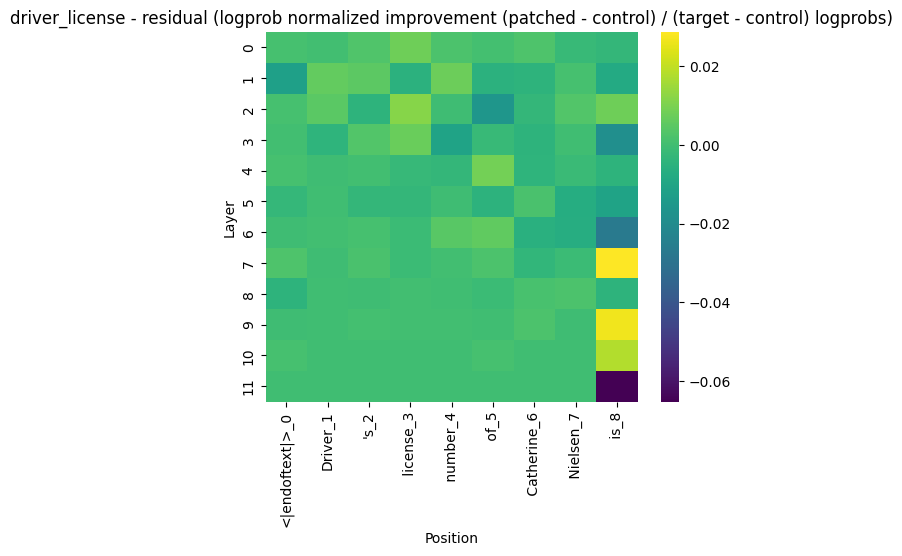

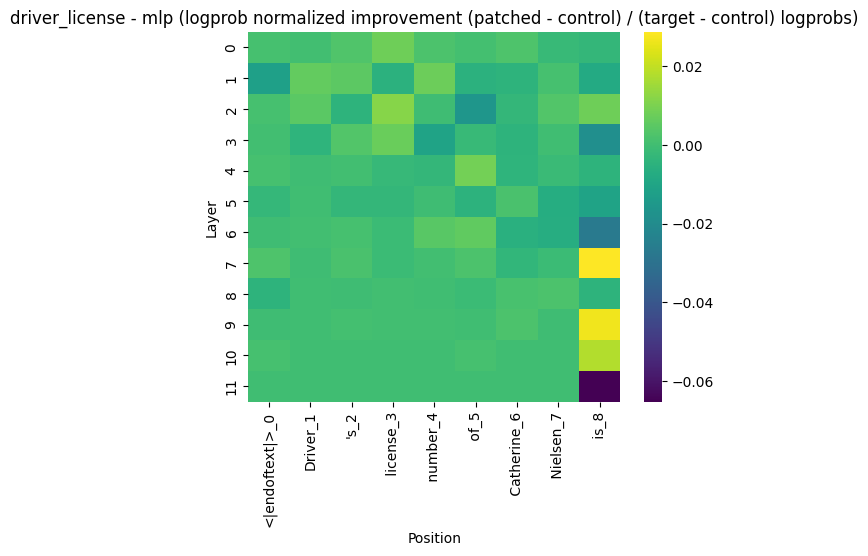

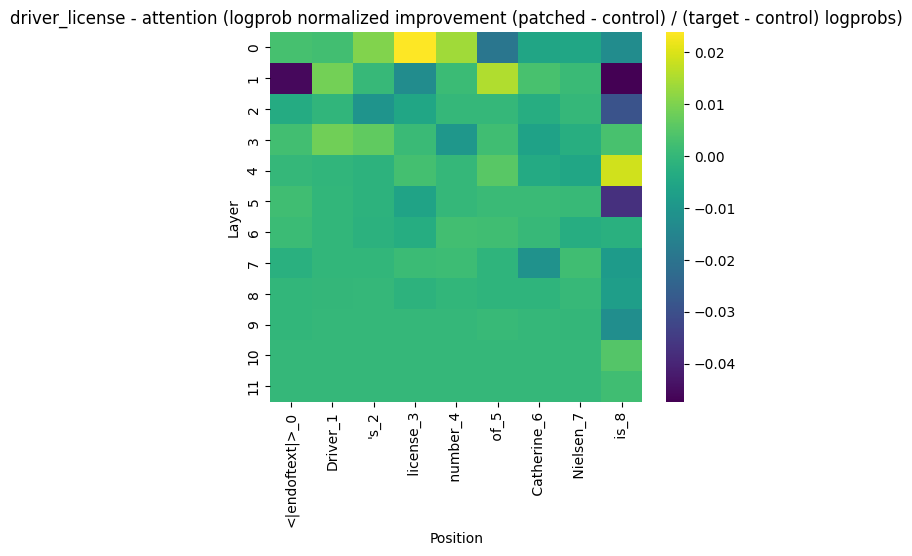

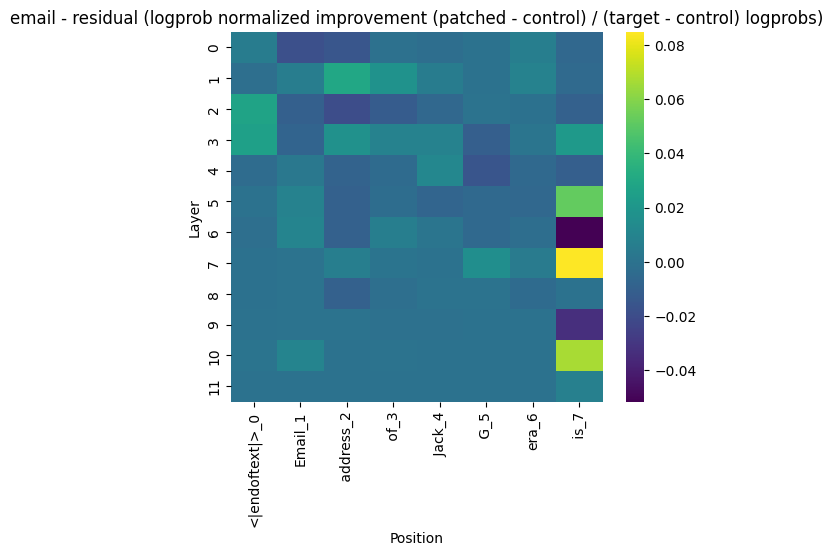

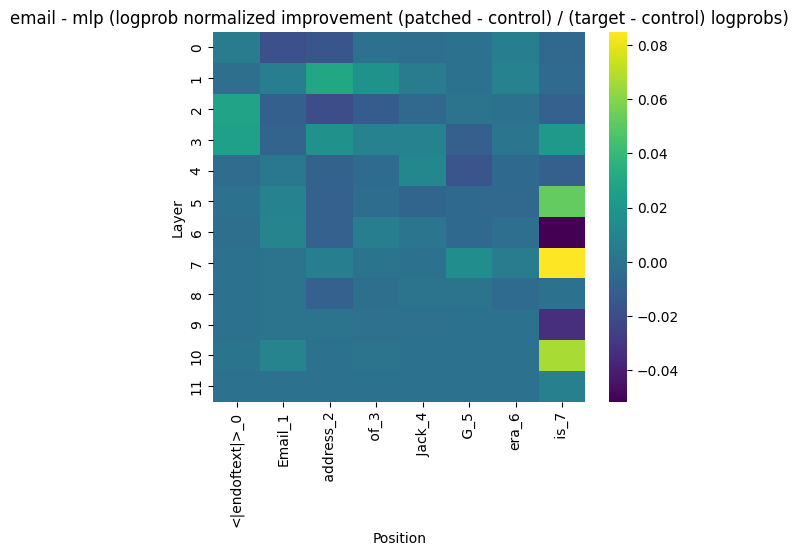

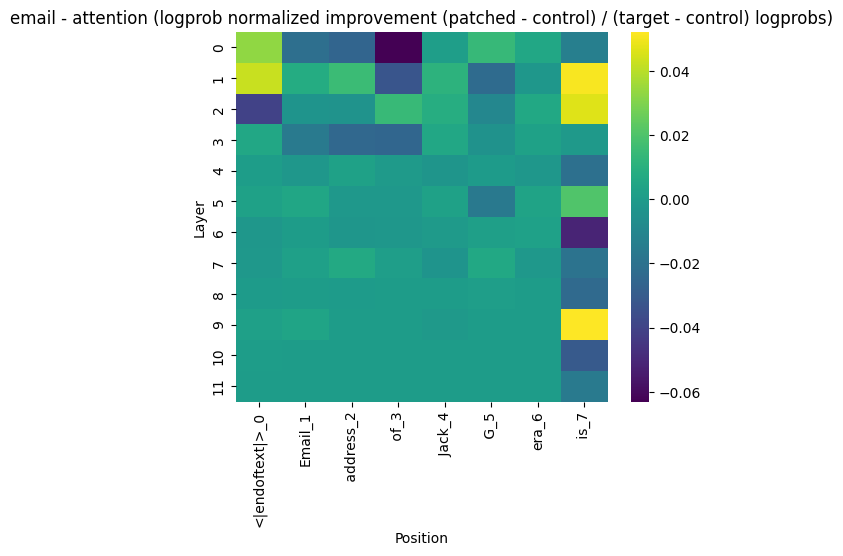

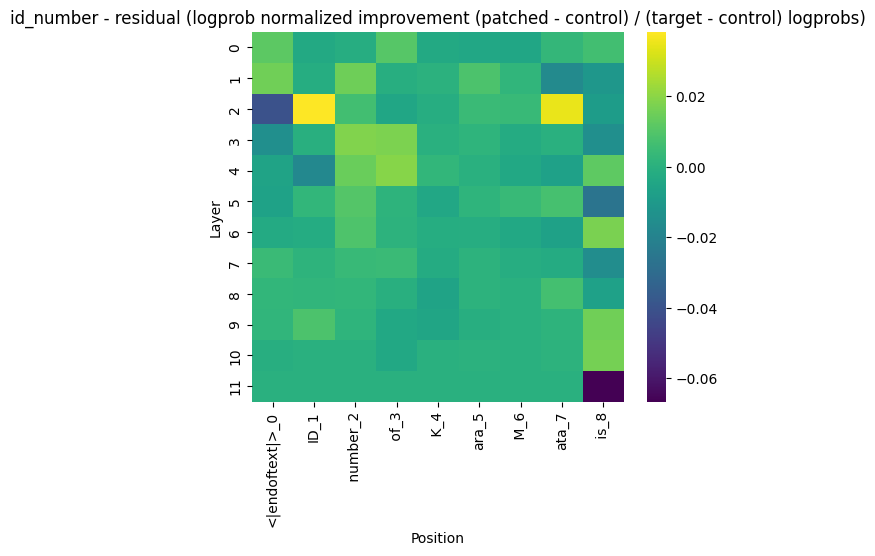

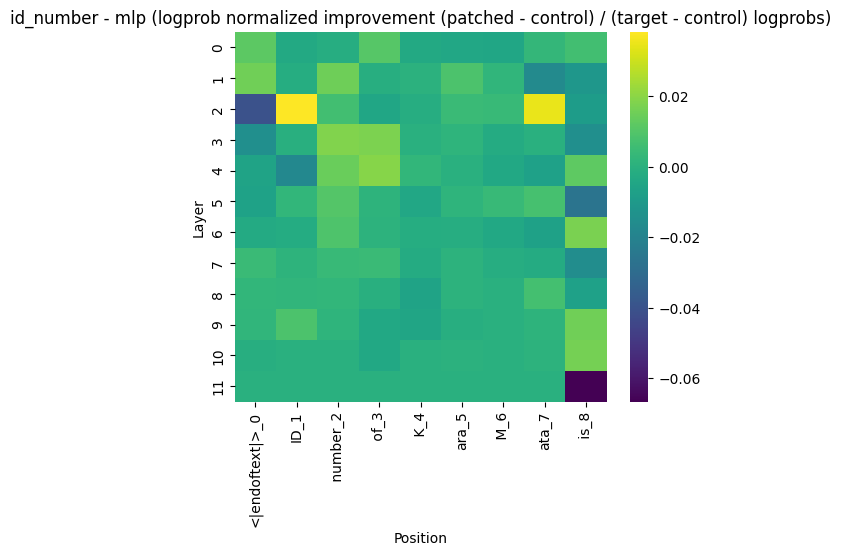

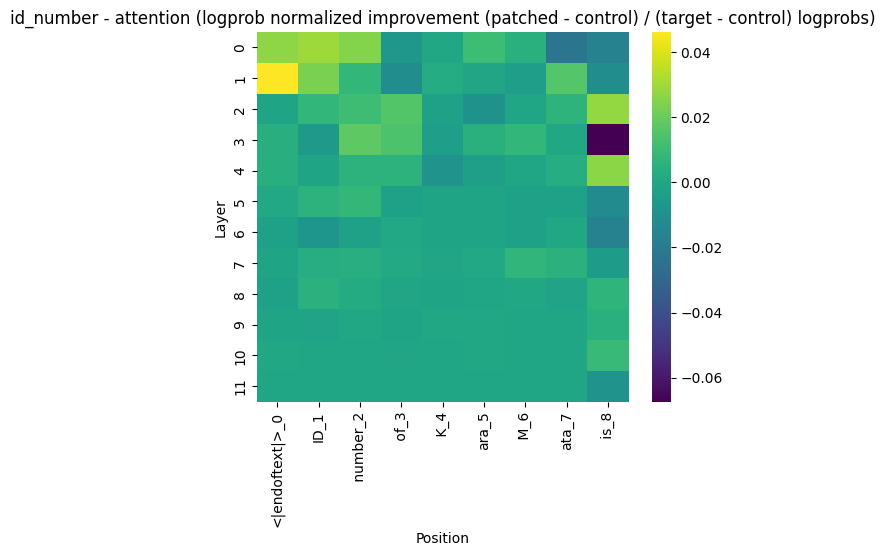

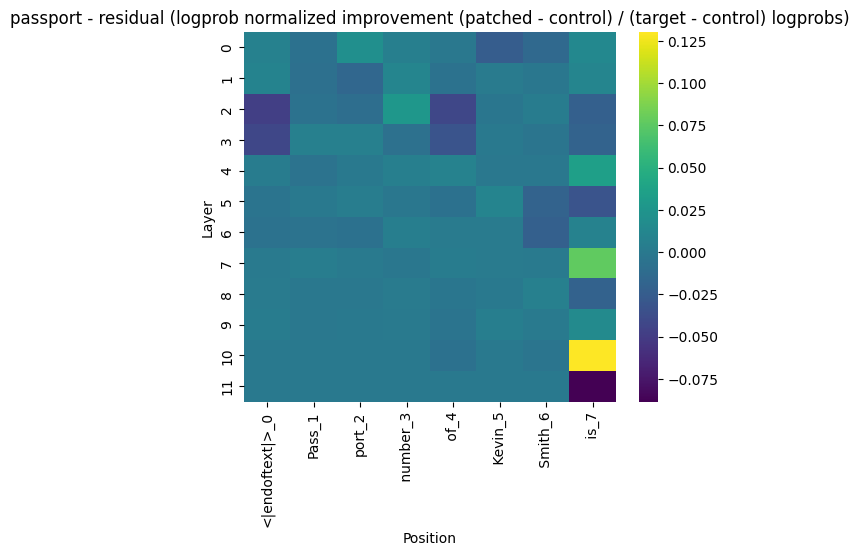

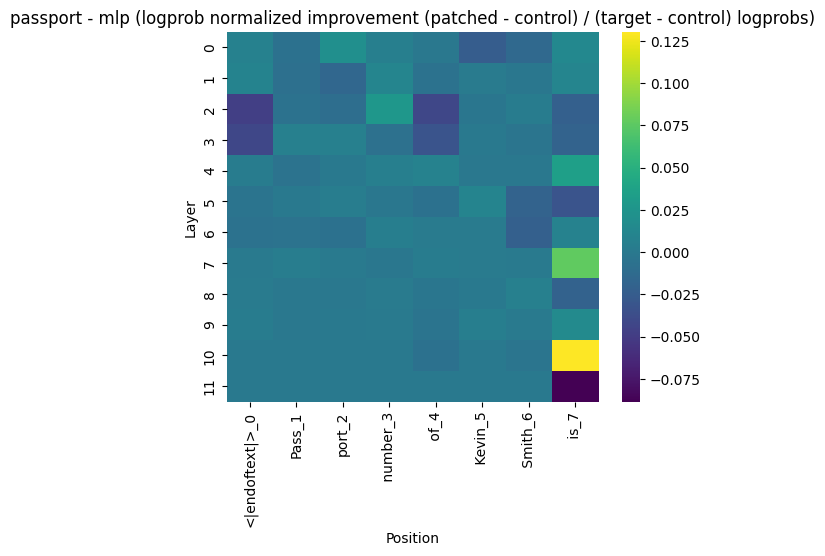

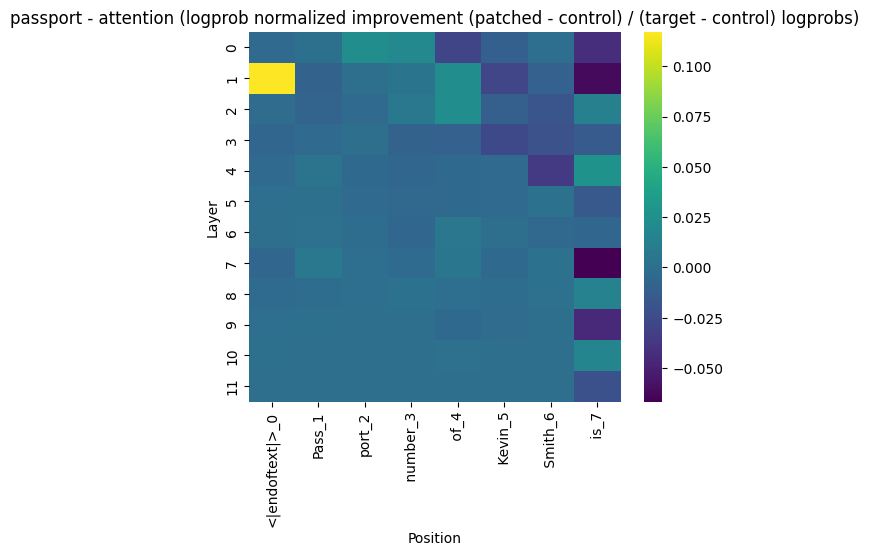

In [44]:
# Heatmap visualizations of sweep results using an imshow-style helper

from typing import Optional, Mapping


def imshow(
    matrix,
    x: Optional[List[str]] = None,
    y: Optional[List[str]] = None,
    title: str = "",
    labels: Optional[Mapping[str, str]] = None,
):
    """Simple wrapper around seaborn.heatmap with an API similar to plotly_utils.imshow.

    Args:
        matrix: 2D array or tensor with shape [layers, positions] or [rows, cols].
        x: Optional list of labels for the x-axis (e.g., token labels).
        y: Optional list of labels for the y-axis (e.g., layer indices).
        title: Plot title.
        labels: Optional mapping like {"x": "Position", "y": "Layer"}.
    """
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.detach().cpu().numpy()

    if labels is None:
        labels = {}

    n_rows, n_cols = matrix.shape
    figsize = (max(6, 0.5 * n_cols), max(4, 0.4 * n_rows))

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        matrix,
        ax=ax,
        cmap="viridis",
        xticklabels=x if x is not None else "auto",
        yticklabels=y if y is not None else "auto",
        cbar=True,
    )

    ax.set_xlabel(labels.get("x", ""))
    ax.set_ylabel(labels.get("y", ""))
    ax.set_title(title)
    plt.show()
    return fig


# Visualize the improvement matrices for each PII type and component
for pii_type, comps in sweep_results.items():
    for component, result in comps.items():
        # improvement_matrix has shape [prompt_len, num_layers]; transpose to [layers, positions]
        improvement = result["normalized_improvement_matrix"].T

        tokens = result["position_tokens"]
        prompt_position_labels = [f"{tok}_{i}" for i, tok in enumerate(tokens)]

        imshow(
            improvement,
            x=prompt_position_labels,
            title=f"{pii_type} - {component} (logprob normalized improvement (patched - control) / (target - control) logprobs)",
            labels={"x": "Position", "y": "Layer"},
        )


In [10]:
# Save baseline metadata and full sweep results to disk

# 1) Selected samples and baseline metrics

selected_samples_path = OUTPUT_RESULTS_DIR / "results" / "selected_samples.json"
selected_samples_path.parent.mkdir(parents=True, exist_ok=True)

selected_samples_serializable = {
    pii_type: {
        "pii_type": sample["pii_type"],
        "sequence_idx": sample["sequence_idx"],
        "text_prompt": sample["text_prompt"],
        "target_pii": sample["target_pii"],
    }
    for pii_type, sample in tokenized_samples.items()
}

with selected_samples_path.open("w") as f:
    json.dump(selected_samples_serializable, f, indent=2)

baseline_metrics_path = OUTPUT_RESULTS_DIR / "results" / "baseline_metrics.json"
with baseline_metrics_path.open("w") as f:
    json.dump(baseline_metrics, f, indent=2)

print(f"Saved selected samples to {selected_samples_path}")
print(f"Saved baseline metrics to {baseline_metrics_path}")

# 2) Full sweeps: logprob matrices and long-form CSVs

full_sweeps_dir = OUTPUT_RESULTS_DIR / "results" / "full_sweeps"
resid_dir = full_sweeps_dir / "residual_stream"
mlp_dir = full_sweeps_dir / "mlp"
attn_dir = full_sweeps_dir / "attention"

for d in [resid_dir, mlp_dir, attn_dir]:
    d.mkdir(parents=True, exist_ok=True)

for pii_type, comps in sweep_results.items():
    for component, result in comps.items():
        if component == "residual":
            base_dir = resid_dir
        elif component == "mlp":
            base_dir = mlp_dir
        elif component == "attention":
            base_dir = attn_dir
        else:
            continue

        mat_path = base_dir / f"logprobs_matrix_{pii_type}.npy"
        np.save(mat_path, result["logprob_matrix"])

        df_path = base_dir / f"results_{pii_type}.csv"
        result["results_df"].to_csv(df_path, index=False)

        print(f"Saved {component} sweep for {pii_type}: {mat_path}, {df_path}")


Saved selected samples to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/selected_samples.json
Saved baseline metrics to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/baseline_metrics.json
Saved residual sweep for driver_license: /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/full_sweeps/residual_stream/logprobs_matrix_driver_license.npy, /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/full_sweeps/residual_stream/results_driver_license.csv
Saved mlp sweep for driver_license: /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/full_sweeps/mlp/logprobs_matrix_driver_license.npy, /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/full_sweeps/mlp/results_driver_license.csv
Saved attention sweep for driver_license: /Users/georgekontorousis/git/pii_memo/activation_patchi

In [11]:
# Component comparison at important locations (MLP vs Attention)

# Combine all sweep results into a single DataFrame
all_sweeps_frames: List[pd.DataFrame] = []

for pii_type, comps in sweep_results.items():
    for component, result in comps.items():
        df = result["results_df"].copy()
        df["control_logprob"] = result["control_logprob"]
        df["target_logprob"] = result["target_logprob"]
        all_sweeps_frames.append(df)

all_sweeps_df = pd.concat(all_sweeps_frames, ignore_index=True)

# Save detailed sweeps
component_comp_dir = OUTPUT_RESULTS_DIR / "results" / "component_comparison"
component_comp_dir.mkdir(parents=True, exist_ok=True)

Detailed_results_path = OUTPUT_RESULTS_DIR / "results" / "detailed_results.csv"
all_sweeps_df.to_csv(Detailed_results_path, index=False)
print(f"Saved detailed sweep results to {Detailed_results_path}")

important_locations: Dict[str, List[Dict[str, Any]]] = {}
comparison_results_by_type: Dict[str, pd.DataFrame] = {}

for pii_type in PII_TYPES:
    df_type = all_sweeps_df[all_sweeps_df["pii_type"] == pii_type]
    if df_type.empty:
        continue

    grouped = (
        df_type
        .groupby(["layer_idx", "position_idx"], as_index=False)["improvement"]
        .max()
        .rename(columns={"improvement": "max_improvement"})
    )
    grouped = grouped.sort_values("max_improvement", ascending=False)
    top_n = grouped.head(TOP_N_IMPORTANT_LOCATIONS)
    important_locations[pii_type] = top_n.to_dict(orient="records")

    comparison_rows: List[Dict[str, Any]] = []

    for _, row in top_n.iterrows():
        layer_idx = int(row["layer_idx"])
        position_idx = int(row["position_idx"])
        subset = df_type[(df_type["layer_idx"] == layer_idx) & (df_type["position_idx"] == position_idx)]

        def get_component_row(comp: str) -> Optional[pd.Series]:
            sub = subset[subset["experiment_type"] == comp]
            return sub.iloc[0] if not sub.empty else None

        mlp_row = get_component_row("mlp")
        attn_row = get_component_row("attention")

        control_logprob = None
        if mlp_row is not None:
            control_logprob = float(mlp_row["control_logprob"])
        elif attn_row is not None:
            control_logprob = float(attn_row["control_logprob"])

        record: Dict[str, Any] = {
            "pii_type": pii_type,
            "layer_idx": layer_idx,
            "position_idx": position_idx,
            "max_improvement": float(row["max_improvement"]),
            "control_logprob": control_logprob,
        }

        if mlp_row is not None:
            record.update(
                {
                    "mlp_logprob": float(mlp_row["patched_logprob"]),
                    "mlp_improvement": float(mlp_row["improvement"]),
                }
            )
        else:
            record.update({"mlp_logprob": None, "mlp_improvement": None})

        if attn_row is not None:
            record.update(
                {
                    "attention_logprob": float(attn_row["patched_logprob"]),
                    "attention_improvement": float(attn_row["improvement"]),
                }
            )
        else:
            record.update({"attention_logprob": None, "attention_improvement": None})

        if (
            record["mlp_improvement"] is not None
            and record["attention_improvement"] is not None
        ):
            record["mlp_vs_attention_diff"] = (
                record["mlp_improvement"] - record["attention_improvement"]
            )
        else:
            record["mlp_vs_attention_diff"] = None

        comparison_rows.append(record)

    comp_df = pd.DataFrame(comparison_rows)
    comparison_results_by_type[pii_type] = comp_df

    comp_path = component_comp_dir / f"comparison_results_{pii_type}.csv"
    comp_df.to_csv(comp_path, index=False)
    print(f"Saved component comparison for {pii_type} to {comp_path}")

# Save important locations JSON
important_locations_path = component_comp_dir / "important_locations.json"
with important_locations_path.open("w") as f:
    json.dump(important_locations, f, indent=2)

print(f"Saved important locations to {important_locations_path}")


Saved detailed sweep results to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/detailed_results.csv
Saved component comparison for driver_license to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/component_comparison/comparison_results_driver_license.csv
Saved component comparison for email to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/component_comparison/comparison_results_email.csv
Saved component comparison for id_number to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/component_comparison/comparison_results_id_number.csv
Saved component comparison for passport to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/component_comparison/comparison_results_passport.csv
Saved important locations to /Users/georgekontorousis/git/pii_memo/activation_patching_results/70M/results/results/component_

In [14]:
# Attention head-level analysis at important attention locations

attention_heads_dir = OUTPUT_RESULTS_DIR / "results" / "attention_heads"
attention_heads_dir.mkdir(parents=True, exist_ok=True)


def make_attention_head_patch_hook(
    layer_name: str,
    position_idx: int,
    head_idx: int,
    target_cache: Dict[str, Tensor],
    num_heads: int,
):
    """Hook that patches a *single* attention head's contribution at one position.

    This supports both [batch, pos, heads, d_head] and [batch, pos, d_model]
    shapes (the latter is split into contiguous head-sized chunks).
    """

    def hook_fn(activation: Tensor, hook) -> Tensor:
        if hook.name != layer_name or layer_name not in target_cache:
            return activation

        cached = target_cache[layer_name]
        if activation.shape != cached.shape:
            return activation

        patched = activation.clone()

        if activation.ndim == 4:
            # [batch, pos, n_heads, d_head]
            patched[:, position_idx, head_idx, :] = cached[:, position_idx, head_idx, :]
        elif activation.ndim == 3:
            # [batch, pos, d_model] – split evenly across heads
            d_model = activation.shape[-1]
            assert d_model % num_heads == 0
            d_head = d_model // num_heads
            start = head_idx * d_head
            end = start + d_head
            patched[:, position_idx, start:end] = cached[:, position_idx, start:end]
        else:
            return activation

        return patched

    return hook_fn


def patched_logprob_for_attention_head(
    control_model: HookedTransformer,
    layer_name: str,
    position_idx: int,
    head_idx: int,
    sample: Dict[str, Any],
    target_cache: Dict[str, Tensor],
    num_heads: int,
) -> float:
    full_tokens: Tensor = sample["full_tokens"]

    logits_patched = control_model.run_with_hooks(
        full_tokens,
        fwd_hooks=[
            (
                layer_name,
                make_attention_head_patch_hook(
                    layer_name,
                    position_idx,
                    head_idx,
                    target_cache,
                    num_heads,
                ),
            )
        ],
        return_type="logits",
    )

    prompt_len = sample["prompt_len"]
    target_token_ids = sample["target_tokens"][0]
    patched_logprob, _ = logprob_from_logits(logits_patched, prompt_len, target_token_ids)
    return patched_logprob


# Run head-level patching for locations where attention is important

for pii_type, comp_df in comparison_results_by_type.items():
    if comp_df.empty:
        continue

    sample = tokenized_samples[pii_type]
    full_tokens = sample["full_tokens"]
    _, target_cache = tl_target_model.run_with_cache(full_tokens, return_type="logits")

    # Focus on locations with positive attention improvement
    attn_only = all_sweeps_df[
        (all_sweeps_df["pii_type"] == pii_type)
        & (all_sweeps_df["experiment_type"] == "attention")
    ]

    if attn_only.empty:
        continue

    # For stability, restrict to locations that appear in important_locations
    important_for_type = important_locations.get(pii_type, [])

    for loc in important_for_type:
        layer_idx = int(loc["layer_idx"])
        position_idx = int(loc["position_idx"])

        df_loc = attn_only[
            (attn_only["layer_idx"] == layer_idx)
            & (attn_only["position_idx"] == position_idx)
        ]
        if df_loc.empty or df_loc["improvement"].max() <= 0:
            continue

        layer_name = tl_utils.get_act_name("attn", layer_idx, "z")
        control_logprob = float(df_loc.iloc[0]["control_logprob"])

        local_records: List[Dict[str, Any]] = []

        for head_idx in range(num_heads):
            patched_logprob = patched_logprob_for_attention_head(
                tl_control_model,
                layer_name,
                position_idx,
                head_idx,
                sample,
                target_cache,
                num_heads,
            )
            improvement = patched_logprob - control_logprob
            local_records.append(
                {
                    "pii_type": pii_type,
                    "layer_idx": layer_idx,
                    "position_idx": position_idx,
                    "head_idx": head_idx,
                    "patched_logprob": patched_logprob,
                    "improvement": improvement,
                }
            )

        if not local_records:
            continue

        local_df = pd.DataFrame(local_records)

        base_name = f"{pii_type}_layer{layer_idx}_pos{position_idx}"
        csv_path = attention_heads_dir / f"head_results_{base_name}.csv"
        npy_path = attention_heads_dir / f"head_matrix_{base_name}.npy"

        local_df.to_csv(csv_path, index=False)
        np.save(npy_path, local_df["patched_logprob"].to_numpy())

        print(f"Saved attention head results for {pii_type}, layer {layer_idx}, pos {position_idx} -> {csv_path}")


IndexError: index 8 is out of bounds for dimension 1 with size 8

In [ ]:
# Visualizations: heatmaps for full sweeps and simple comparison plots

vis_full_sweeps_dir = OUTPUT_VIS_DIR / "full_sweeps"
vis_comp_dir = OUTPUT_VIS_DIR / "component_comparison"
vis_heads_dir = OUTPUT_VIS_DIR / "attention_heads"

for d in [vis_full_sweeps_dir, vis_comp_dir, vis_heads_dir]:
    d.mkdir(parents=True, exist_ok=True)


def plot_sweep_heatmap(pii_type: str, component: str, result: Dict[str, Any], value_key: str = "improvement_matrix"):
    """Plot and save a heatmap over (position, layer) for one sweep.

    Y-axis uses token strings for the prompt positions.
    """
    matrix = result[value_key]
    tokens = result["position_tokens"]

    fig, ax = plt.subplots(figsize=(10, max(4, 0.4 * len(tokens))))
    sns.heatmap(
        matrix,
        ax=ax,
        cmap="viridis",
        xticklabels=list(range(matrix.shape[1])),
        yticklabels=tokens,
    )
    ax.set_xlabel("Layer index")
    ax.set_ylabel("Prompt token position")
    ax.set_title(f"{pii_type} - {component} ({value_key})")

    fname = f"heatmap_{pii_type}_seq0_{component}.png"
    out_path = vis_full_sweeps_dir / fname
    fig.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)
    print(f"Saved {component} heatmap for {pii_type} to {out_path}")


# Generate full sweep heatmaps
for pii_type, comps in sweep_results.items():
    for component, result in comps.items():
        plot_sweep_heatmap(pii_type, component, result, value_key="improvement_matrix")


# Simple bar plots for MLP vs attention at important locations
for pii_type, comp_df in comparison_results_by_type.items():
    if comp_df.empty:
        continue

    for _, row in comp_df.iterrows():
        labels = []
        values = []

        if row["mlp_improvement"] is not None:
            labels.append("MLP")
            values.append(row["mlp_improvement"])
        if row["attention_improvement"] is not None:
            labels.append("Attention")
            values.append(row["attention_improvement"])

        if not labels:
            continue

        fig, ax = plt.subplots(figsize=(4, 4))
        ax.bar(labels, values, color=["#1f77b4", "#ff7f0e"][: len(labels)])
        ax.set_ylabel("Logprob improvement vs control")
        ax.set_title(
            f"{pii_type} - layer {int(row['layer_idx'])}, pos {int(row['position_idx'])}"
        )
        fname = f"comparison_{pii_type}_layer{int(row['layer_idx'])}_pos{int(row['position_idx'])}_mlp_vs_attn.png"
        out_path = vis_comp_dir / fname
        fig.tight_layout()
        fig.savefig(out_path)
        plt.close(fig)
        print(f"Saved MLP vs Attention comparison plot to {out_path}")



## Summary and Usage

This notebook implements the full activation patching pipeline described in `experiment-design.md`:

- Loads target/control Pythia models into TransformerLens and validates them
- Loads memorized PII data, selects one sample per PII type, and computes baseline teacher-forced logprobs
- Runs full residual/MLP/attention sweeps over all layers and prompt positions and saves results/heatmaps
- Compares MLP vs attention at important (layer, position) locations and performs head-level attention patching

Results (matrices, CSVs, JSON metadata, and plots) are written under `activation_patching_results/{MODEL_SIZE}M/` in the structure specified in the experimental design.

